# Linear Regression

首先把需要用到的包都引入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
df = pd.read_csv('Data.csv')
df = df.drop(['ID'], axis=1)


我们画出热力图，选取与 `MEDV` 相关性较大的特征，并做线性回归

<AxesSubplot:>

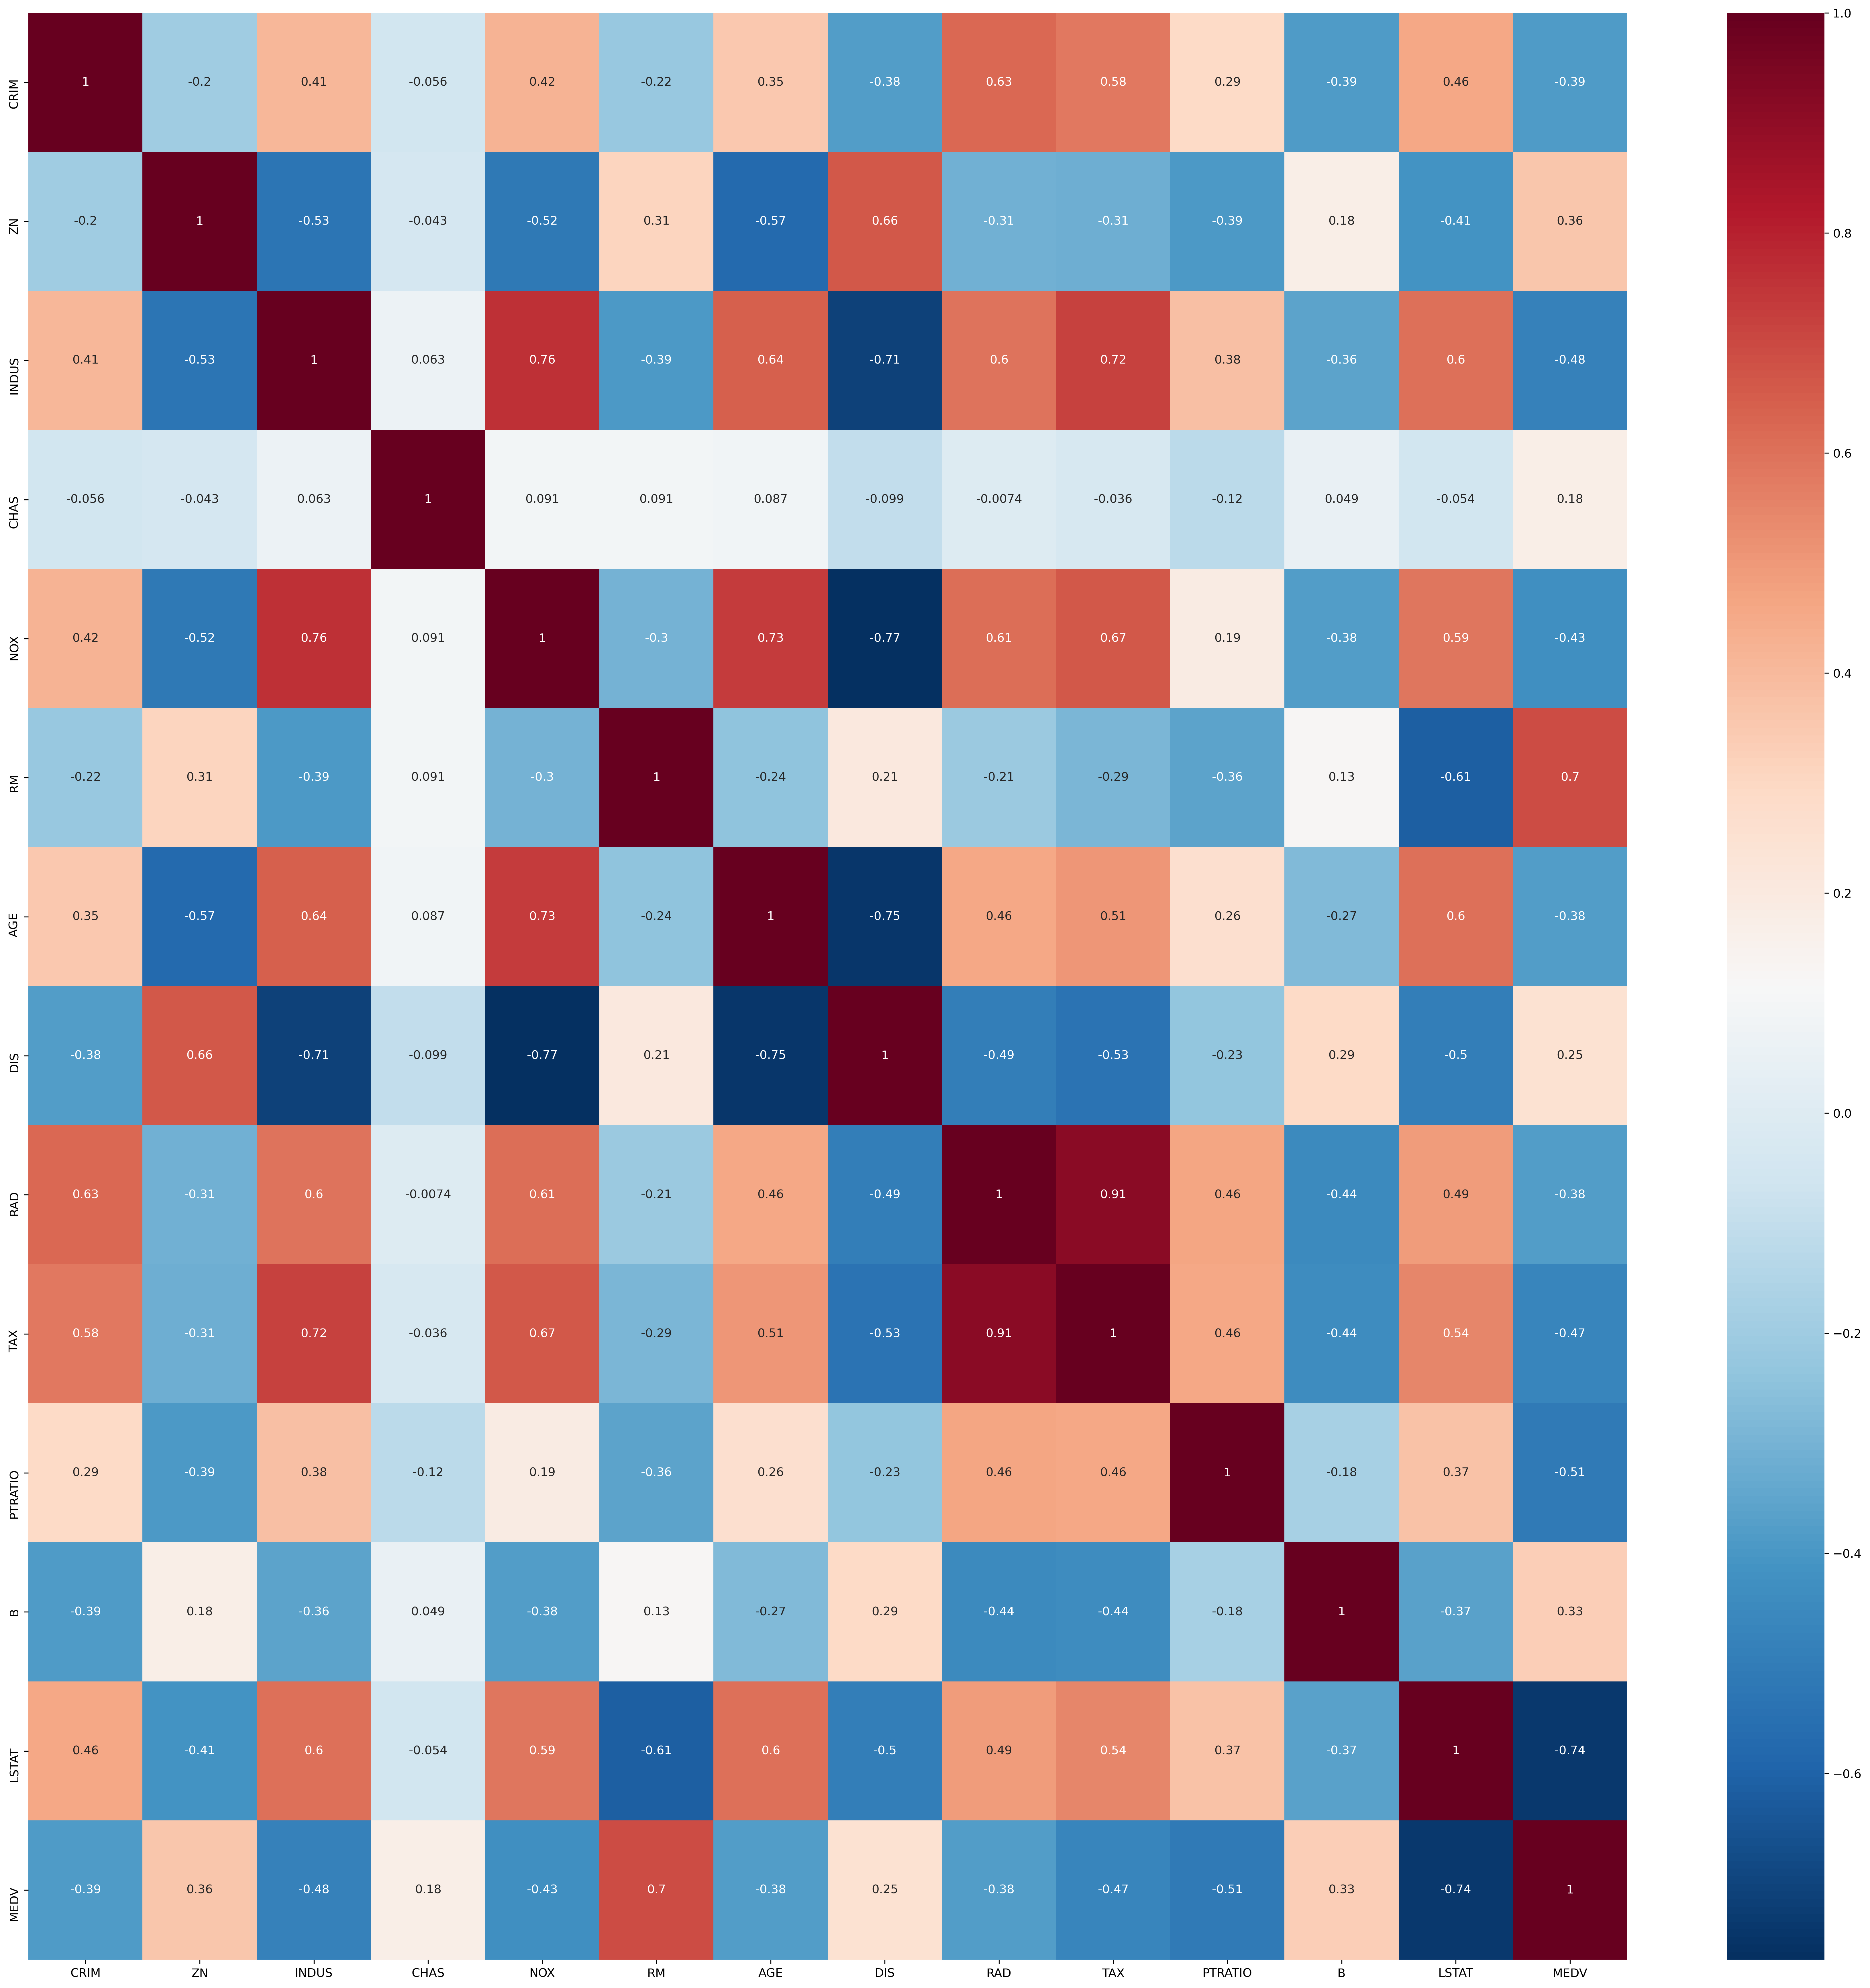

In [3]:
plt.figure(dpi=300, figsize=(30, 30))
sns.heatmap(df.corr(), cmap='RdBu_r', annot=True)

这里选取与 `MEDV` 相关系数大于 0.4 或小于 -0.4 的特征

并且为了防止数据溢出，我们对数据进行归一化处理，这里做最值归一化，也就是：

$$
x_{scale} = \frac{x - x_{min}}{x_{max} - x_{min}}
$$

In [4]:
Y = df['MEDV'].to_numpy()
X = df.drop(['MEDV', 'CHAS', 'DIS', 'B', 'CRIM', 'AGE', 'RAD'], axis=1).to_numpy()

X = (X - np.min(X)) / (np.max(X) - np.min(X))
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))

train_X, test_X, train_Y, test_Y = train_test_split(
    X, Y, test_size=0.3, shuffle=True)


## 实验主体：

实现一个 `LinearRegression` 类，具体要求见 `README.md`

In [5]:
"""
start Lab 01
"""

import random


def mse(x, y):
    return (x - y) ** 2 / 2


class LinearRegression(object):
    def __init__(self, X, alpha=0.001, epoch=10000, optimizer='basic'):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        self.alpha = alpha
        self.epoch = epoch
        self.loss = []
        self.optimizer = optimizer

    def calc_loss(self, X, Y):
        sum = 0
        frac = Y.shape[0]
        for i in range(Y.shape[0]):
            sum += mse(np.dot(self.w, X[i]) + self.b, Y[i]) / frac
        self.loss.append(sum)

    def fit_basic(self, X, Y):
        frac = Y.shape[0]
        for _ in range(self.epoch):
            self.calc_loss(X, Y)
            temp_w = np.zeros(X.shape[1])
            temp_b = 0
            for i in range(Y.shape[0]):
                temp_w += self.alpha * \
                    (self.w.T @ X[i] + self.b - Y[i]) * X[i] / frac
                temp_b += self.alpha * (self.w.T @ X[i] + self.b - Y[i]) / frac
            self.w = self.w - temp_w
            self.b = self.b - temp_b

    def fit_adam(self, X, Y):
        frac = Y.shape[0]
        m, v = 0, 0
        prev = np.ones(X.shape[1])
        t = 0
        while np.linalg.norm(self.w - prev) >= 1e-8 and t <= self.epoch:
            self.calc_loss(X, Y)
            t = t + 1
            prev = self.w
            i = random.randint(0, frac - 1)
            g = np.array([(self.w.T @ X[i] + self.b - Y[i]) *
                         X[i], (self.w.T @ X[i] + self.b - Y[i])])
            m = self.beta_1 * m + (1 - self.beta_1) * g
            v = self.beta_2 * v + (1 - self.beta_2) * \
                (g[0].T @ g[0] + g[1] * g[1])
            temp_m = m / (1 - pow(self.beta_1, t))
            temp_v = v / (1 - pow(self.beta_2, t))
            self.w = self.w - self.alpha * \
                temp_m[0] / (np.sqrt(temp_v) + self.eps)
            self.b = self.b - self.alpha * \
                temp_m[1] / (np.sqrt(temp_v) + self.eps)
            self.learn_rate.append(self.alpha / (np.sqrt(temp_v) + self.eps))

    def fit(self, X, Y):
        if self.optimizer == 'basic':
            self.fit_basic(X, Y)
        else:
            self.beta_1 = 0.9
            self.beta_2 = 0.999
            self.eps = 1e-8
            self.learn_rate = []
            self.fit_adam(X, Y)

    def predict(self, X):
        y = []
        for i in range(X.shape[0]):
            y.append(self.w.T @ X[i] + self.b)
        return np.array(y)



## 测试

当然你可以更改这部分代码，写自己的测试程序，但务必完成实验中的要求

结果展示：

1. 朴素的梯度下降

2. `Adam` 算法，这里我记录了其学习率的变化

In [6]:
def R_2(y_pred, y_true):
    mean = np.mean(y_true)
    sst = np.sum((y_pred - mean)**2)
    ssr = np.sum((y_true - mean)**2)
    return sst / ssr


lr = LinearRegression(train_X, alpha=0.05)
lr.fit(train_X, train_Y)


朴素梯度下降

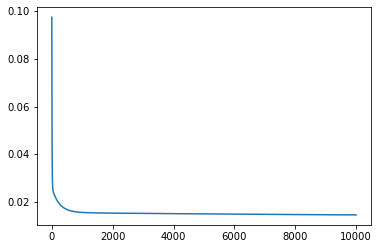

MSE : 0.02
R^2 in train : 26.69
R^2 in test: 27.05


In [7]:
x = [i for i in range(len(lr.loss))]

plt.plot(x, lr.loss)
plt.show()

y_pred = lr.predict(test_X)
error = 0
for i in range(y_pred.shape[0]):
    error += mse(y_pred[i], test_Y[i]) / y_pred.shape[0]
print("MSE : %.2f" % error)
print("R^2 in train : %.2f" % (R_2(lr.predict(train_X), train_Y) * 100))
print("R^2 in test: %.2f" % (R_2(y_pred, test_Y) * 100))


使用 `Adam` 算法

In [8]:
lr = LinearRegression(train_X, optimizer='adam', alpha=0.05)
lr.fit(train_X, train_Y)

<ipython-input-5-ac407d3fcc0c>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  g = np.array([(self.w.T @ X[i] + self.b - Y[i]) *


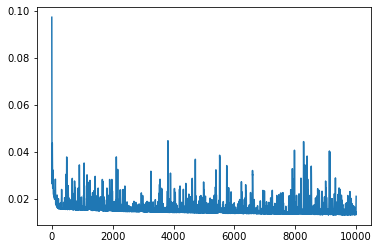

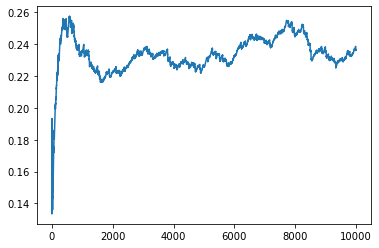

MSE : 0.02
R^2 in train : 81.06
R^2 in test: 77.07


In [9]:
x = [i for i in range(lr.epoch + 1)]

plt.plot(x, lr.loss)
plt.show()

plt.plot(x, lr.learn_rate)
plt.show()

y_pred = lr.predict(test_X)
error = 0
for i in range(y_pred.shape[0]):
    error += mse(y_pred[i], test_Y[i]) / y_pred.shape[0]
print("MSE : %.2f" % error)
print("R^2 in train : %.2f" % (R_2(lr.predict(train_X), train_Y) * 100))
print("R^2 in test: %.2f" % (R_2(y_pred, test_Y) * 100))

用了一些 tricky （归一化什么的），然后调了一下学习率，事实证明学习率的调整是很有必要的，如果你有在记录梯度的范数的话，你会发现其实梯度一直都没有降下来，反而在上升，但由于我们的学习率太小了，所以梯度还没到降下来的时候，我们就已经达到了最大迭代次数，就只能退出了。

这就给我们一个启发，就是你不知道为什么模型结果很差的时候，可以去看看梯度的范数是不是真的到0了，因为可能它并没有卡在驻点，相反它甚至还在下降，但你的最大迭代次数限制了它的优化。还是需要把那个总结的图多看看。